In [73]:
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import torch

DEVICE = torch.device('cuda')

INPUT_WIDTH = 224
INPUT_HEIGHT = 224

paths_labeled = list(Path('train/simpsons_dataset').glob('**/*.jpg'))
paths_test = list(Path('testset/testset').glob('**/*.jpg'))

label_encoder = LabelEncoder().fit([f.parent.name for f in paths_labeled])

from torchvision import transforms

pre_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

from sklearn.model_selection import train_test_split
paths_train, paths_val = train_test_split(paths_labeled)

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision

class SimpsonsDataset(Dataset):
    def __init__(self, filepaths, has_labels=True):
        super().__init__()
        self.filepaths = sorted(filepaths)
        self.has_labels = has_labels
        self.labels = [label_encoder.transform([f.parent.name])[0] for f in self.filepaths] if has_labels else None

    def __getitem__(self, index):
        img = Image.open(self.filepaths[index])
        X = pre_transforms(img)
        return (X, self.labels[index]) if self.has_labels else X

    def __len__(self):
        return len(self.filepaths)

dataset_train = SimpsonsDataset(paths_train)
dataset_val = SimpsonsDataset(paths_val)
dataset_test = SimpsonsDataset(paths_test, has_labels=False)

import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

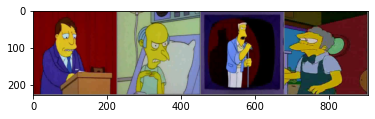

['mayor_quimby' 'charles_montgomery_burns' 'rainier_wolfcastle'
 'moe_szyslak']


In [74]:
images, labels = iter(DataLoader(dataset_train, batch_size=4, shuffle=True)).next()
imshow(torchvision.utils.make_grid(images))
print(label_encoder.inverse_transform(labels))

In [81]:
from tqdm import tqdm

def train_one_epoch(model, data_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    model.train()
    for x_batch, y_batch in tqdm(data_loader, 'train epoch batches'):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * x_batch.size(0)
        running_corrects += torch.sum(preds == y_batch).item()
        processed_size += x_batch.size(0)
    
    return running_loss / processed_size, running_corrects / processed_size

In [35]:
from tqdm import tqdm

def validate_one_epoch(model, data_loader, criterion):
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(data_loader, 'validate epoch batches'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * x_batch.size(0)
            running_corrects += torch.sum(preds == y_batch).item()
            processed_size += x_batch.size(0)
    
    return running_loss / processed_size, running_corrects / processed_size

In [101]:
from tqdm import tqdm

def run_predict(model, data_loader):
    logits = []
    model.eval()
    with torch.no_grad():
        for x_batch in tqdm(data_loader, 'test epoch batches'):
            x_batch = x_batch.to(DEVICE)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, 1)
            logits.append(preds)
    
    return torch.cat(logits)

In [90]:
import torchvision.models as models

model = models.alexnet(pretrained=True).to(DEVICE)
model.classifier[6] = nn.Linear(4096, len(label_encoder.classes_)).to(DEVICE)
for p in model.features[:-5].parameters():
    p.requires_grad_(False)

history = []
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

loader_train = DataLoader(dataset_train, batch_size=256, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=256)

for _ in tqdm(range(20), 'epochs'):
    train_loss, train_acc = train_one_epoch(model, loader_train, criterion, optimizer)
    val_loss, val_acc = validate_one_epoch(model, loader_val, criterion)
    history.append((loss_train, acc_train, loss_val, acc_val))

0:19<00:04,  1.12s/it]

validate epoch batches:  86%|████████▌ | 18/21 [00:20<00:03,  1.10s/it]

validate epoch batches:  90%|█████████ | 19/21 [00:21<00:02,  1.10s/it]

validate epoch batches:  95%|█████████▌| 20/21 [00:22<00:01,  1.13s/it]

epochs:  85%|████████▌ | 17/20 [28:16<04:56, 98.99s/it]

train epoch batches:   0%|          | 0/62 [00:00<?, ?it/s]

train epoch batches:   2%|▏         | 1/62 [00:01<01:16,  1.25s/it]

train epoch batches:   3%|▎         | 2/62 [00:02<01:14,  1.24s/it]

train epoch batches:   5%|▍         | 3/62 [00:03<01:13,  1.25s/it]

train epoch batches:   6%|▋         | 4/62 [00:04<01:11,  1.24s/it]

train epoch batches:   8%|▊         | 5/62 [00:06<01:10,  1.24s/it]

train epoch batches:  10%|▉         | 6/62 [00:07<01:09,  1.24s/it]

train epoch batches:  11%|█▏        | 7/62 [00:08<01:08,  1.24s/it]

train epoch batches:  13%|█▎        | 8/62 [00:09<01:06,  1.24s/it]

train epoch batches:  15%|█▍        | 9/62 [00:11<01:04,  1.22s/it]

train epoch batche

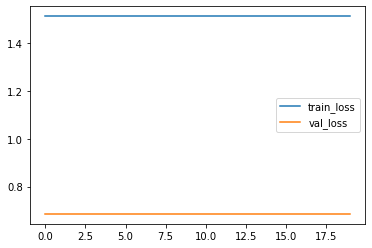

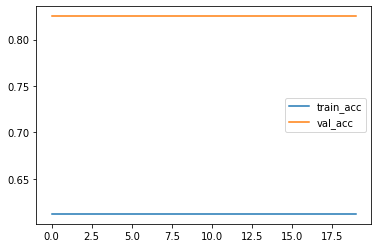

In [96]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend(loc='best')
plt.show()

plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend(loc='best')
plt.show()

In [92]:
train_loss, train_acc = train_one_epoch(model, loader_train, criterion, optimizer)
train_loss, train_acc

train epoch batches: 100%|██████████| 62/62 [01:16<00:00,  1.23s/it]


(0.10436919695845501, 0.9768138097968023)

In [103]:
preds = run_predict(model, DataLoader(dataset_test, batch_size=256))

test epoch batches: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


array([29,  4, 28,  7,  2, 16, 11,  7, 20, 16, 18, 22, 16, 28, 27,  9,  0,
       11, 16, 20, 22, 29,  9, 24, 15,  2, 17, 17, 28, 11,  2,  7,  2, 28,
       22,  0, 15, 37, 20,  6,  7, 16,  0, 25, 18,  0, 29,  9,  7, 29, 22,
        6,  2, 24, 20, 11, 11,  6, 28,  7, 15,  6, 22,  2, 18, 18,  9, 16,
        6, 37, 28, 28,  9,  6, 11,  4, 16, 28, 17, 14,  7, 24, 28, 17, 37,
       28,  7, 29,  0, 17, 15, 17, 20, 17, 24, 20, 27, 29, 22,  4,  7, 25,
        7, 16, 22, 20,  2,  6, 22,  2, 22,  2, 24, 22, 11, 15, 15,  4, 32,
       11, 25, 27, 18, 27, 32, 15, 18, 20, 37,  7,  2, 24,  6, 24, 16, 27,
       15, 20, 25,  2, 24,  6,  6,  4, 20, 20,  7, 27, 37, 20, 11, 17, 16,
       15,  6, 18, 29,  7, 29, 24, 15, 29, 22,  9, 15,  6, 18, 22,  2, 29,
       24,  4,  2, 15, 18, 25, 17,  0, 20,  0,  7, 15, 15, 17, 18, 18, 16,
        6, 37,  7, 11, 16,  2, 29,  4,  6, 24, 24,  7,  4,  0, 15, 29,  0,
       11,  7, 18, 28, 27, 22, 22, 16, 27,  6,  9,  2,  4, 11, 32, 18,  9,
       27, 17, 29, 17, 25

In [107]:
import pandas as pd
pd.DataFrame({ 'Id': [f.name for f in dataset_test.filepaths], 'Expected': label_encoder.inverse_transform(preds.cpu().numpy()) }).to_csv('submission.csv', index=None)